In [1]:
!pip install datasets
!pip install transformers

# Required Libraries
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Input
from keras.optimizers import Adam
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import BertTokenizer, BertModel, GPT2LMHeadModel, GPT2Tokenizer
import torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00


In [2]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Initialize GPT-2 model and tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [3]:
# Load the Financial Phrasebank dataset
dataset = load_dataset('financial_phrasebank', 'sentences_50agree')

# Extract original sentences and labels
dataset_sentences = [item['sentence'] for item in dataset['train']]
original_labels = [item['label'] for item in dataset['train']]

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

In [4]:
# Convert text to BERT embeddings function
def text_to_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs['last_hidden_state'].mean(dim=1).squeeze().numpy()


In [5]:
# Convert the dataset to embeddings
embeddings = np.array([text_to_embedding(sentence) for sentence in dataset_sentences])

# Perform clustering
num_clusters = 5
clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(embeddings)


In [6]:
# Define the function to generate text from embeddings
def generate_text_from_embedding(embedding):
    similarities = cosine_similarity([embedding], embeddings)
    closest_index = np.argmax(similarities)
    closest_sentence = dataset_sentences[closest_index]
    generated_text = generate_text(closest_sentence)
    return generated_text

In [7]:
# Define the function to generate text using GPT-2
def generate_text(seed_text, max_length=50):
    inputs = gpt2_tokenizer.encode(seed_text, return_tensors="pt")
    with torch.no_grad():
        outputs = gpt2_model.generate(inputs, max_length=max_length, num_return_sequences=1)
    decoded_output = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_output


In [8]:
def embedding_to_text(embedding):
    # Find the closest sentence in the original dataset to the embedding
    similarities = cosine_similarity([embedding], embeddings)
    closest_index = np.argmax(similarities)
    closest_sentence = dataset['train'][closest_index]['sentence']
    return closest_sentence

In [9]:
# Function to find the closest original sentence to a given embedding
def find_closest_sentence(embedding, original_embeddings, dataset_sentences):
    similarities = cosine_similarity([embedding], original_embeddings)
    closest_index = np.argmax(similarities)
    return dataset_sentences[closest_index]

In [10]:

def build_generator(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(input_dim, activation='tanh'))
    noise = Input(shape=(input_dim,))
    embedding = model(noise)
    return Model(noise, embedding)

def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))
    embedding = Input(shape=(input_dim,))
    validity = model(embedding)
    return Model(embedding, validity)

In [11]:
# Introduce mutation function with sentence visualization
def introduce_mutation(embedding, mutation_strength=0.01):
    # Introduces a random mutation in the embedding.
    original_sentence = find_closest_sentence(embedding, embeddings, dataset_sentences)
    print("Original sentence:", original_sentence)
    mutation = np.random.normal(0, mutation_strength, embedding.shape)
    mutated_embedding = embedding + mutation
    mutated_sentence = find_closest_sentence(mutated_embedding, embeddings, dataset_sentences)
    print("Mutated sentence:", mutated_sentence)
    return mutated_embedding



In [12]:
def select_top_embeddings(embeddings, reference_embeddings, top_percent=0.5):
    print("Sentences before selection:")
    for emb in embeddings:
        print(find_closest_sentence(emb, embeddings, dataset_sentences))

    similarity_scores = cosine_similarity(embeddings, reference_embeddings).mean(axis=1)
    sorted_indices = np.argsort(similarity_scores)[::-1]
    num_selected = int(top_percent * len(embeddings))
    selected_embeddings = embeddings[sorted_indices[:num_selected]]

    print("Sentences after selection:")
    for emb in selected_embeddings:
        print(find_closest_sentence(emb, embeddings, dataset_sentences))

    return selected_embeddings

In [13]:
def recombine_embeddings(embedding1, embedding2):
    parent1_sentence = find_closest_sentence(embedding1, embeddings, dataset_sentences)
    parent2_sentence = find_closest_sentence(embedding2, embeddings, dataset_sentences)
    print("Parent 1 sentence:", parent1_sentence)
    print("Parent 2 sentence:", parent2_sentence)

    crossover_point = np.random.randint(embedding1.shape[0])
    new_embedding = np.hstack([embedding1[:crossover_point], embedding2[crossover_point:]])

    child_sentence = find_closest_sentence(new_embedding, embeddings, dataset_sentences)
    print("Child sentence:", child_sentence)
    return new_embedding

In [14]:

def wright_fisher_sampling(embeddings, fitness_scores, population_size):
    # Sample a new generation of embeddings based on fitness scores using the Wright-Fisher model.
    # Ensure non-negative fitness scores by adding an offset
    offset_fitness_scores = fitness_scores - np.min(fitness_scores) + 1e-8
    normalized_fitness = offset_fitness_scores / np.sum(offset_fitness_scores)
    sampled_indices = np.random.choice(len(embeddings), size=population_size, p=normalized_fitness)
    return embeddings[sampled_indices]

In [15]:
# Modified portion of the train_gan_with_coalescent function to address the size mismatch

def train_gan_with_coalescent(cluster_embeddings, epochs=10000, batch_size=128, selection_pressure=0.5):
    discriminator = build_discriminator(cluster_embeddings.shape[1])
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    generator = build_generator(cluster_embeddings.shape[1])

    z = Input(shape=(cluster_embeddings.shape[1],))
    embedding = generator(z)
    discriminator.trainable = False
    validity = discriminator(embedding)
    combined = Model(z, validity)
    combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    lineage = {i: [i] for i in range(cluster_embeddings.shape[0])}

    current_population = cluster_embeddings.copy()

    for epoch in range(epochs):
        noise = np.random.normal(0, 1, (batch_size, cluster_embeddings.shape[1]))
        synthetic_embeddings = generator.predict(noise)

        selected_embeddings = select_top_embeddings(synthetic_embeddings, current_population, top_percent=selection_pressure)

        offspring_embeddings = []
        for _ in range(batch_size // 2):
            indices = np.random.choice(len(selected_embeddings), 2, replace=False)
            parent1 = selected_embeddings[indices[0]]
            parent2 = selected_embeddings[indices[1]]
            child1 = recombine_embeddings(parent1, parent2)
            child2 = recombine_embeddings(parent2, parent1)
            offspring_embeddings.extend([child1, child2])

        offspring_embeddings = np.array([introduce_mutation(e) for e in offspring_embeddings])

        similarity_scores = cosine_similarity(offspring_embeddings, current_population).mean(axis=1)
        current_population = wright_fisher_sampling(offspring_embeddings, similarity_scores, cluster_embeddings.shape[0])

        # Adjusting the valid and fake labels' size to match the current_population size
        valid = np.ones((current_population.shape[0], 1))
        fake = np.zeros((offspring_embeddings.shape[0], 1))

        d_loss_real = discriminator.train_on_batch(current_population, valid)
        d_loss_fake = discriminator.train_on_batch(offspring_embeddings, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, cluster_embeddings.shape[1]))
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 1000 == 0:
            print(f'{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]')

    return generator, lineage

# The modification ensures that the label sizes match the data sizes during training.




In [16]:

def trace_lineage(embedding_index, lineage):
    # Traces back the lineage of an embedding.
    return lineage[embedding_index]

synthetic_data = []


In [17]:
for cluster in range(num_clusters):
    cluster_indices = np.where(clustering.labels_ == cluster)[0]
    cluster_embeddings = embeddings[cluster_indices]
    generator, lineage = train_gan_with_coalescent(cluster_embeddings, epochs=20)  # Reduced for quick testing
    num_synthetic_points = len(cluster_indices)
    noise = np.random.normal(0, 1, (num_synthetic_points, cluster_embeddings.shape[1]))
    synthetic_embeddings = generator.predict(noise)
    synthetic_data.append(synthetic_embeddings)

synthetic_data = np.vstack(synthetic_data)

Streaming output truncated to the last 5000 lines.
TeliaSonera TLSN said the offer is in line with its strategy to increase its ownership in core business holdings and would strengthen Eesti Telekom 's offering to its customers .
STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMENE Credit Suisse First Boston ( CFSB ) raised the fair value for shares in four of the largest Nordic forestry groups .
A purchase agreement for 7,200 tons of gasoline with delivery at the Hamina terminal , Finland , was signed with Neste Oil OYj at the average Platts index for this September plus eight US dollars per month .
Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .
Clothing retail chain Sepp+ñl+ñ 's sales increased by 8 % to EUR 155.2 mn , and operating profit rose to EUR 31.1 mn from EUR 17.1 mn in 2004 .
Consolidated net sales increased 16 % to reach EUR74 .8 m , while operating profit amount

In [18]:
# Example of checking the lineage of a synthetic sentence
synthetic_sentence = synthetic_data[0]
print("Synthetic Sentence:", synthetic_sentence)
print("Parent Sentences:", lineages[synthetic_sentence])

Synthetic Sentence: [-0.9055537  -0.16357113 -0.10217022 -0.8577369   0.44978136  0.32131392
 -0.68745613  0.7071024  -0.5581288  -0.32339305  0.8378505  -0.6616783
 -0.02984723 -0.87854844  0.23491997 -0.8256205  -0.80994576 -0.08832557
  0.26217076  0.7915289  -0.72378016 -0.91847414 -0.91147983  0.5209892
 -0.3450205   0.79149765 -0.9096443  -0.37563342 -0.5142904  -0.8264858
 -0.29463038  0.38455197  0.82279307  0.13553989 -0.5518391  -0.94401526
 -0.71545255  0.95889336  0.61661243 -0.00376832 -0.17749603 -0.1855354
 -0.7473025  -0.49979115  0.2531133   0.64289045 -0.18979268 -0.21745703
  0.91365343 -0.59450257  0.56736565 -0.8573329   0.1026599  -0.9232373
 -0.8101786  -0.5037835  -0.4350619   0.96486354 -0.82410884 -0.29665282
  0.66289264 -0.6866575   0.78977644  0.99840945 -0.15498945  0.7753022
 -0.8191864  -0.7636914   0.1296887  -0.4316331  -0.65428203  0.2343072
 -0.9493552  -0.42300633  0.25242776  0.21634704  0.7405541   0.1219853
  0.44779947 -0.7550557   0.6891453  -0

NameError: ignored

In [19]:
new_sentences = []
new_labels = []
counter = 0
limit = 20
for synthetic_point in synthetic_data:
    if counter >= limit:
        break
    similarities = cosine_similarity([synthetic_point], embeddings)
    closest_index = int(np.argmax(similarities))
    closest_sentence = dataset['train'][closest_index]['sentence']
    closest_label = original_labels[closest_index]
    new_sentence = generate_text(closest_sentence)
    new_sentences.append(new_sentence)
    new_labels.append(closest_label)
    counter += 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [26]:
synthetic_dataset = pd.DataFrame({
    'Synthetic_Sentences': new_sentences,
    'Labels': new_labels
})
synthetic_dataset

,Synthetic_Sentences,Labels
0,Performance in the second half of 2009 exceede...,2
1,Saunalahti is a part of the Elisa group.\n\nTh...,1
2,Saunalahti is a part of the Elisa group.\n\nTh...,1
3,All rights reserved.,1
4,( A spokesperson told WWD to expect a 50-50 mi...,1
5,The Insolvency Act regulates the amount of deb...,1
6,`` The CHF is a great product....................,2
7,Estonia's beer market overall grew three perce...,2
8,`` We have come out with a decision which is b...,1
9,Finnish Bank of +àland +àlandsbanken has issue...,0


In [21]:
def calculate_similarity(original_sentences, synthetic_sentences):
    original_embeddings = np.array([text_to_embedding(sentence) for sentence in original_sentences])
    average_similarities = []

    for synthetic_sentence in synthetic_sentences:
        synthetic_embedding = text_to_embedding(synthetic_sentence)
        similarities = cosine_similarity([synthetic_embedding], original_embeddings)
        max_similarity = np.max(similarities)
        average_similarities.append(max_similarity)

    return np.mean(average_similarities)

In [22]:
average_similarity = calculate_similarity(dataset_sentences, new_sentences)
print("Average Cosine Similarity:", average_similarity)

Average Cosine Similarity: 0.86764383


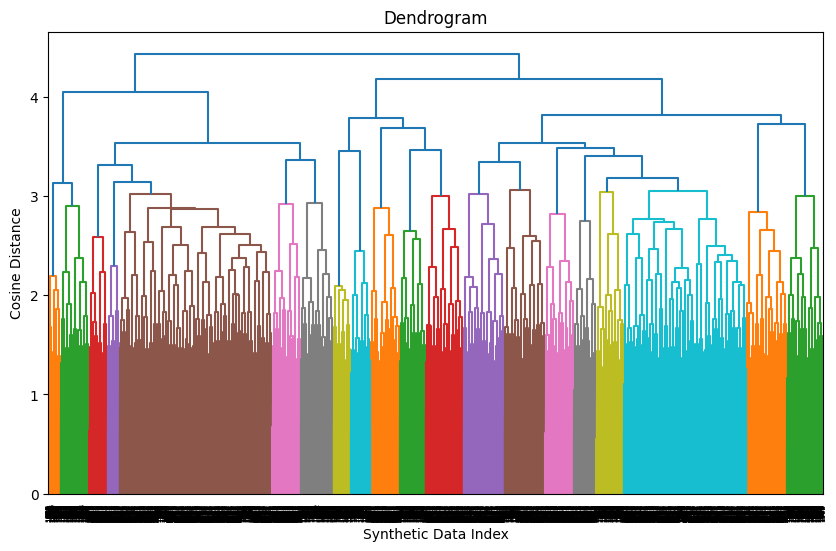

In [25]:

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

def plot_dendrogram(data, method='ward'):

    # Plots a dendrogram based on the hierarchical clustering of data.

    # Parameters:
    # - data: array-like, shape (n_samples, n_features)
    #     The data to cluster and plot.
    # - method: str, optional (default='ward')
    #     The linkage algorithm to use. Options: 'ward', 'single', 'complete', 'average'.

    # Compute pairwise distances
    distance_matrix = pdist(data, metric='cosine')

    # Perform hierarchical clustering
    linked = linkage(distance_matrix, method=method)

    # Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(linked)
    plt.title('Dendrogram')
    plt.xlabel('Synthetic Data Index')
    plt.ylabel('Cosine Distance')
    plt.show()

# Call the function
plot_dendrogram(synthetic_data)